**Saroj Duwal**    
**2479434**    
**Finals**    

## Introduction

This file contains solution for the final exam. I have implemented a character level lanugage model in three ways:
- GRU
- LSTM
- Transformer   

For each step, I have described my work before calling the function.

## Data and Cleanup

I have used Agnes Grey by Anne Bronte as my training dataset. This book can be found under Project Glutenberg and is free to use. There was no particular reason for choosing this book. I chose a book that was familiar to me.    

The training dataset only uses lowercase letters (a-z). I have removed all the punctuations, numbers, and special characters (âà’“”—‘éêëû) found in the dataset. We split each words and use keras tokenizer to vectorize the text corpus. We create a n-gram sequence for each word. All the tokens are padded such they their length is equal to the maximum length of word found in the corpus. The process I followed during preprocessing is similar to method described [here](https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275).


In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np 
from string import digits, punctuation
import keras.utils as ku 

In [2]:
tokenizer = Tokenizer(lower=True, char_level=True)

In [3]:
def preprocessing(data):

  removePunc = str.maketrans('','', punctuation)
  removeNumber = str.maketrans('','',digits)
  removeSpecial = str.maketrans('','','âà’“”—‘éêëû')

  # remove punctuations, special characters and numbers
  corpus = data.lower().split()
  corpus = [s.translate(removeNumber) for s in corpus]
  corpus = [s.translate(removePunc) for s in corpus]
  corpus = [s.translate(removeSpecial) for s in corpus]

  corpus = list(filter(None, corpus)) # Removes the empty line 

  tokenizer.fit_on_texts(corpus)
  totalWords = len(tokenizer.word_index)+1

  input = []

  # tokenize the words
  for line in corpus:
    tokenList = tokenizer.texts_to_sequences([line])[0]
    for i in range(0,len(tokenList)):
      n_gram = tokenList[:i+1]
      input.append(n_gram)

  maxLength = max([len(x) for x in input])
  # pad all the n-gram tokens to max length found in the document
  input = np.array(pad_sequences(input,maxlen=maxLength,padding='pre'))

  # split the dataset into training data and results. The results are converted to binary class matrix.
  predictors, label = input[:,:-1],input[:,-1]
  label=ku.to_categorical(label,num_classes=totalWords)
  return predictors, label, maxLength, totalWords

In [4]:
# tokenizer.word_index #Helpful if you want to compare the vector to actual word

In [6]:
# Open the file and process the text
inputFile = 'data.txt'
data = open(inputFile,"r")
x, y, maxLength, totalWords = preprocessing(data.read())
maxLength

22

**Example**

**Predictor**: [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  4, 18,  6]    
*Word: agn*

**Label**: [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]   
*target: e*

We will use the same input and output for all our models. 

## Text Generation and common methods

This method will be used to generate the next char in the sequence. The method predicts the class with the highest probability, finds the word in the token and return the char form. For our example demostration, we will only generate one char at a time, although we could generate multiple characters. 

For multiple characters, the generated char is appeneded to the input and the new sequence is considered input for next character. 

```python
generate_text("agn",1,maxLength,model)
```

In [6]:
def generate_text(seed_text, next_words, max_sequence_len, model):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list)
        predicted = np.argmax(model.predict(token_list), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += output_word
    return seed_text


### Plot   
This was used to plot accuracy vs validation accuracy during training.

In [7]:
from matplotlib import pyplot as plt

def plot_accuracy_vs_val(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

### Common parameters

In [39]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

epochs = 100
patience = 10
verbose = 1

'''
This callback is used while training the models. 
If there is no improvement in validation accuracy in 10 consecutive epoch, the training stops.
This tries to maximize the validation accuracy.
'''
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=patience)


'''
Optimizer for the model
uses the adam algorithm to control the learning rate
'''
opt = Adam(learning_rate=0.001)

In [33]:
# saves the trained model
def saveModel(filename,model):
  filename +=".tf"

  print()
  print(f"Saving model as {filename}")
  model.save(filename)
  print("Model has been saved.")

## RNN   

I have used simpleRNN from keras library. There are no gates present in the library. This model has a simple architecure with an Embedding, SimpleRNN and Dense layer. 

The embedding layer allows us to represent the input with  dense vector representation. The embedding layer gives us 2D vector representation with one embedding for each word in the input and processes using the simpleRNN layer. There is a dropout layer which is a regularization layer to prevent overfitting (Stack overflow suggested that using a dropout layer was better than using recurrent_dropout property in simpleRNN).  Finally, we have a dense layer with softmax activation. Softmax converts the vector value to a probablity distribution. Based on the keras documentation, this seemed like the best activation function to use.



In [15]:
from keras.layers import Embedding, Dense, Dropout, SimpleRNN
from keras.models import Sequential

from sklearn.model_selection import train_test_split

In [16]:
def simpleRNN(x, y, maxLength, totalWords):
  inputLength = maxLength-1

  model = Sequential()
  model.add(Embedding(totalWords, 64, input_length=inputLength))
  model.add(SimpleRNN(150))
  model.add(Dropout(0.1))
  model.add(Dense(totalWords,activation='softmax'))

  # loss as suggested in keras docs "Use this when there are two or more class labels"
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  # Used sklearn library to split as suggested in stack overflow 
  # This would help prevent overfitting as we don't want to resample validation set after each epoch
  # splits the data set in 80-20 split. Trained on the 80% and the rest is used to validation (unseen data to generalize the model)
  x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True,test_size=0.2)
  history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epochs, verbose=verbose, callbacks=[es])

  plot_accuracy_vs_val(history)

  return model

Epoch 1/100
7262/7262 [==============================] - 95s 13ms/step - loss: 2.3115 - accuracy: 0.2921 - val_loss: 1.9259 - val_accuracy: 0.3944
Epoch 2/100
7262/7262 [==============================] - 94s 13ms/step - loss: 1.9337 - accuracy: 0.3890 - val_loss: 1.8490 - val_accuracy: 0.4259
Epoch 3/100
7262/7262 [==============================] - 94s 13ms/step - loss: 1.8567 - accuracy: 0.4107 - val_loss: 1.7690 - val_accuracy: 0.4453
Epoch 4/100
7262/7262 [==============================] - 93s 13ms/step - loss: 1.8174 - accuracy: 0.4233 - val_loss: 1.7443 - val_accuracy: 0.4507
Epoch 5/100
7262/7262 [==============================] - 93s 13ms/step - loss: 1.7960 - accuracy: 0.4294 - val_loss: 1.7535 - val_accuracy: 0.4533
Epoch 6/100
7262/7262 [==============================] - 93s 13ms/step - loss: 1.7806 - accuracy: 0.4348 - val_loss: 1.7212 - val_accuracy: 0.4585
Epoch 7/100
7262/7262 [==============================] - 93s 13ms/step - loss: 1.7721 - accuracy: 0.4369 - val_loss: 1

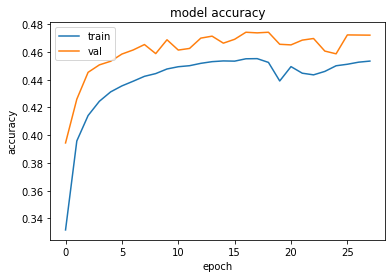


Saving model as simplernn.tf
INFO:tensorflow:Assets written to: simplernn.tf/assets
Model has been saved.


In [17]:
# create and save the model
simplernn = simpleRNN(x,y,maxLength,totalWords)
saveModel("simplernn",simplernn)

## GRU   
For GRU, I have used keras GRU layer. The architecture for my GRU model is similar to simpleRNN. Instead of simpleRNN, I have used the GRU layer. This model has a single GRU layer followed by a Dense layer. The number of unit was chosen randomly (and should be optimized for better result). 

The model has a fully connected output layer that outputs one vector with a probability distribution across all characters in the vocabulary. A softmax activation function is used on the output layer to ensure the output has the properties of a probability distribution. (same as above)

In [19]:
from keras.layers import GRU

In [20]:
def gru(x, y, maxLength, totalWords):
  inputLength = maxLength-1

  model = Sequential()
  model.add(Embedding(totalWords, 64, input_length=inputLength))
  model.add(GRU(150))
  model.add(Dropout(0.1))
  model.add(Dense(totalWords,activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True,test_size=0.2)
  history=model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epochs, verbose=verbose, callbacks=[es])

  plot_accuracy_vs_val(history)

  return model

Epoch 1/100
7262/7262 [==============================] - 212s 29ms/step - loss: 2.1138 - accuracy: 0.3419 - val_loss: 1.7598 - val_accuracy: 0.4423
Epoch 2/100
7262/7262 [==============================] - 210s 29ms/step - loss: 1.7506 - accuracy: 0.4424 - val_loss: 1.6766 - val_accuracy: 0.4616
Epoch 3/100
7262/7262 [==============================] - 210s 29ms/step - loss: 1.6682 - accuracy: 0.4638 - val_loss: 1.6390 - val_accuracy: 0.4735
Epoch 4/100
7262/7262 [==============================] - 212s 29ms/step - loss: 1.6276 - accuracy: 0.4754 - val_loss: 1.6265 - val_accuracy: 0.4759
Epoch 5/100
7262/7262 [==============================] - 214s 29ms/step - loss: 1.6118 - accuracy: 0.4787 - val_loss: 1.6181 - val_accuracy: 0.4712
Epoch 6/100
7262/7262 [==============================] - 213s 29ms/step - loss: 1.5948 - accuracy: 0.4819 - val_loss: 1.6045 - val_accuracy: 0.4834
Epoch 7/100
7262/7262 [==============================] - 213s 29ms/step - loss: 1.5879 - accuracy: 0.4840 - val_

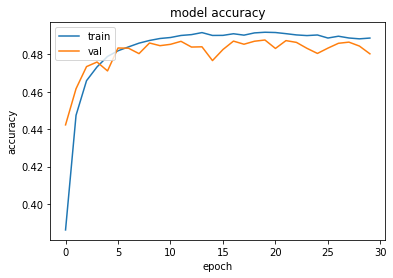


Saving model as gruModel.tf


INFO:tensorflow:Assets written to: gruModel.tf/assets


INFO:tensorflow:Assets written to: gruModel.tf/assets


Model has been saved.


In [21]:
# create and save the model
gruModel = gru(x,y,maxLength,totalWords)
saveModel("gruModel",gruModel)

## Transformers   
I have implemented encoder only transformer for this model. This architecture is similar to the one described in keras code [example](https://keras.io/examples/nlp/text_classification_with_transformer/). The encoder is model as shown [here](https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png). I have used keras embedding layer for token embedding and positional embedding. 

The model has 4 layers of encoder and has a global average pool. GlobalAveragePooling1D helps to represent the vector better. We used this as a better alternative to "flatten" the tensor we get from embedding. 

In [23]:
from keras.layers import Layer, Embedding, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Input
import tensorflow as tf
import keras

In [24]:
# This is used as embedding layer in the transformer. 
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    # This method was needed to save it to h5 format, but tf does not need this override
    # def get_config(self):
    #   config = super().get_config().copy()
    #   config.update({
    #       "token_emb":self.token_emb,
    #       "pos_emb":self.pos_emb
    #   })

    #   return config

In [25]:
def pointWiseFeedForwardNetwork(d_model, dff):
  return Sequential([
                     Dense(dff, activation="relu"),
                     Dense(d_model)
                    ])

In [26]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = pointWiseFeedForwardNetwork(embed_dim,ff_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [40]:

'''
Transformer model with only the encoder. The transformer block is the encoder
Same as previous architectures, but with transformers. I have used 4 (randomly selected) encoder layers in this architecture.
epoch =10 ,early stopping patience =3

Initially, this was run with the same config as other model, but took too long. 
The model was trained for more than 50 epoch and had accuracy of over 41% (in initial run)
'''
def transformerModel(x, y, maxLength, totalWords, layers=4):
  embedding_layer = TokenAndPositionEmbedding(maxLength, totalWords, 32)
  transformer_block = TransformerBlock(embed_dim=32, num_heads=1, ff_dim=32)

  inputs = Input(shape=(maxLength-1,))

  outputs = embedding_layer(inputs)

  for i in range(layers):
    outputs = transformer_block(outputs)
  outputs = GlobalAveragePooling1D()(outputs)

  outputs = Dropout(0.1)(outputs)
  outputs = Dense(totalWords, activation="softmax")(outputs)

  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=['accuracy'])
  x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, verbose=verbose, callbacks=[es])

  plot_accuracy_vs_val(history)
  return model


Epoch 1/10
7262/7262 [==============================] - 182s 25ms/step - loss: 2.4546 - accuracy: 0.2500 - val_loss: 2.1565 - val_accuracy: 0.3268
Epoch 2/10
7262/7262 [==============================] - 177s 24ms/step - loss: 2.1712 - accuracy: 0.3249 - val_loss: 2.0498 - val_accuracy: 0.3622
Epoch 3/10
7262/7262 [==============================] - 178s 25ms/step - loss: 2.1061 - accuracy: 0.3397 - val_loss: 2.0331 - val_accuracy: 0.3550
Epoch 4/10
7262/7262 [==============================] - 178s 25ms/step - loss: 2.0676 - accuracy: 0.3506 - val_loss: 2.0093 - val_accuracy: 0.3597
Epoch 5/10
7262/7262 [==============================] - 179s 25ms/step - loss: 2.0524 - accuracy: 0.3538 - val_loss: 1.9798 - val_accuracy: 0.3688
Epoch 6/10
7262/7262 [==============================] - 179s 25ms/step - loss: 2.0329 - accuracy: 0.3598 - val_loss: 1.9746 - val_accuracy: 0.3785
Epoch 7/10
7262/7262 [==============================] - 178s 24ms/step - loss: 2.0231 - accuracy: 0.3616 - val_loss: 1

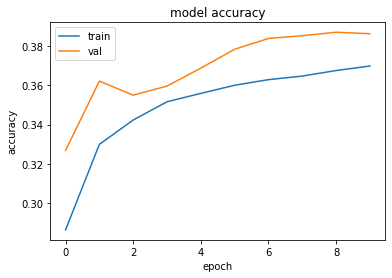


Saving model as transformer.tf


INFO:tensorflow:Assets written to: transformer.tf/assets


INFO:tensorflow:Assets written to: transformer.tf/assets


Model has been saved.


In [41]:
# create and save the model
transformer = transformerModel(x,y,maxLength,totalWords)

saveModel("transformer",transformer)

## Generating Next

We have trained our model. We can use them to generate text as below:


In [59]:
model = gruModel #model from before
generate_text("conten",1,maxLength,model)

# x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=123)
# model.evaluate(x_test,y_test)

1816/1816 [==============================] - 15s 8ms/step - loss: 1.5247 - accuracy: 0.4970


[1.524666428565979, 0.496978759765625]

## Load saved model

The saved model are stored as a zip file. You will need to unzip the file before you can load the model. Each model is named as follows:

|Model|Zip File|Model Name|
|--|--|--|
|SimpleRNN|simplernn.zip|simplernn.tf|
|GRU|gruModel.zip|gruModel.tf|
|Transformer|transformer.zip|transformer.tf|

In [ ]:
# Use this line if uploading the zip file in google collab
# !unzip simplernn.zip #use as zipFile.zip

In [53]:
from keras.models import load_model

In [54]:
filename = "transformer.tf" #model name. Look table above
m = load_model(filename)

m.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding_5  (None, 21, 32)       1568        input_6[0][0]                    
__________________________________________________________________________________________________
transformer_block_5 (Transforme (None, 21, 32)       6464        token_and_position_embedding_5[0]
                                                                 transformer_block_5[0][0]        
                                                                 transformer_block_5[1][0]        
                                                                 transformer_block_5[2][0]  

In [28]:
generate_text("agn",1,maxLength,m)

'agne'

## Comparisons

Following table shows accuracy for each model:


|Model|Learning rate| Number of epoch| Accuracy (in %)|
|--|--|--|--|
|SimpleRNN|0.01|12|31.10|
|GRU|0.01|14|33.72|
|Transformer|0.01|11|12.25|
|SimpleRNN|0.001|28|47.65|
|GRU|0.001|30|49.70|
|Transformer|0.001|10|38|

Note:
- Number of epoch is the number of epoch that actually ran. For simpleRNN and GRU, early stopping halts the process if there is no progress.
- I initially ran the program with 0.01 learning rate, but the accuray was below par. I the decided to run it with 0.001 which is the default value. 
- The graphs of accuracy and validation shows that the model generalizes well. 

**Time to train**   
Although RNN and GRU took similar time to run, transformers were very timing consuming for this architecture. This is mainly due to the number of layers I had in transformer. For RNN and GRU, there is a single layer of RNN and GRu, whereas there are 4 layers of transformer block present in the transformer model. 

**Accuracy**   
The given accuacy we got might be misleading as we didn't have same training params. For example: due to time constraints, we ran transformer models for 10 epochs only where as other models trained for much longer.

**Improvements**
- Longer training
- better tuning of the parameters. Most of the parameters are chosen randomly and can be further optimized.
- More layers. I have the simplest architeture to make it work, but we can see better performance with more layers (a better architecture)



## References

- [Agnes Grey](https://www.gutenberg.org/ebooks/767) (Training Dataset) 
- [When to change data to categorical](https://stackoverflow.com/questions/44110426/when-to-use-to-categorical-in-keras) (Used during preprocessing)
- [Train test split](https://datascience.stackexchange.com/questions/38955/how-does-the-validation-split-parameter-of-keras-fit-function-work) 
-[GlobalAveragePool](https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras)

- https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

- https://stackoverflow.com/questions/12851791/removing-numbers-from-string

- https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275

- https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/

- https://keras.io/examples/nlp/text_classification_with_transformer/

- [Transformer Tensorflow](https://www.tensorflow.org/tutorials/text/transformer)